In [163]:
import matplotlib.pyplot as plt
import pickle
import cv2
import os
import keras as ks
import numpy as np
import pandas as pd
import csv
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            classification_report, roc_curve, auc)
from sklearn.model_selection import train_test_split, KFold,  GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.utils import resample
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import ListedColormap

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
# roc curve and auc score
from sklearn.datasets import make_classification  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.manifold import TSNE



seed = 2019

In [36]:
mobile = ks.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), 
                                                  include_top=False, 
                                                  weights='imagenet', 
                                                  pooling='avg')

In [37]:
mobile.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [48]:
#Funcion para generar los features y labels
def load_images_from_folder(folder, label, model):
    features_labels = []

    for filename in tqdm(os.listdir(folder)):

        img_path = os.path.join(folder,filename)
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)

        assert img is not None

        features_labels.append((feature,label))

    return features_labels

In [19]:
enfermos = load_images_from_folder("fondo_de_ojo_train/enfermo/", "enfermo" , mobile)

100%|██████████| 827/827 [01:20<00:00, 10.88it/s]


In [20]:
sanos = load_images_from_folder("fondo_de_ojo_train/sano", "sano" , mobile)

100%|██████████| 815/815 [01:17<00:00, 11.27it/s]


In [38]:
lista=enfermos+sanos

NameError: name 'enfermos' is not defined

In [39]:
np.save("lista", lista)

NameError: name 'lista' is not defined

In [40]:
np.load("lista.npy")

array([[array([[0.05, 2.71, 0.11, ..., 0.36, 0.1 , 0.29]], dtype=float32),
        'enfermo'],
       [array([[0.54, 1.35, 1.05, ..., 0.03, 0.39, 0.01]], dtype=float32),
        'enfermo'],
       [array([[0.12, 2.3 , 0.09, ..., 0.  , 0.01, 0.24]], dtype=float32),
        'enfermo'],
       ...,
       [array([[0.03, 3.24, 0.  , ..., 0.  , 0.26, 0.09]], dtype=float32),
        'sano'],
       [array([[0.  , 3.19, 0.01, ..., 0.  , 0.  , 0.04]], dtype=float32),
        'sano'],
       [array([[0.01, 1.25, 0.32, ..., 0.  , 0.  , 0.44]], dtype=float32),
        'sano']], dtype=object)

In [41]:
# la lista anterior asignarle a una variable
listas = np.load("lista.npy")

In [42]:
x = []
y = []

for tupla in listas:
    x.append(tupla[0][0])
    y.append(tupla[1])

In [43]:
X = np.array(x)

In [44]:
Y = np.array(y)

In [45]:
#separar en x e y ... empezar a dividir Train, Val, Test
# Usaremos 70% para entrenamiento y 30% para evaluacion
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)
print('Tamaño X_train: {}'.format(X_train.shape))
print('Tamaño Y_train: {}'.format(Y_train.shape))
print('Tamaño X_test: {}'.format(X_test.shape))
print('Tamaño Y_test: {}'.format(Y_test.shape))

Tamaño X_train: (1149, 1280)
Tamaño Y_train: (1149,)
Tamaño X_test: (493, 1280)
Tamaño Y_test: (493,)


In [46]:
# Dividiremos lo de train y el val  -- 50% es train, y el 20% validacion
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.28, random_state=seed)
print('Tamaño X_train: {}'.format(X_train.shape))
print('Tamaño Y_train: {}'.format(Y_train.shape))
print('Tamaño X_test: {}'.format(X_test.shape))
print('Tamaño Y_test: {}'.format(Y_test.shape))
print('Tamaño X_val: {}'.format(X_val.shape))
print('Tamaño Y_val: {}'.format(Y_val.shape))

Tamaño X_train: (827, 1280)
Tamaño Y_train: (827,)
Tamaño X_test: (493, 1280)
Tamaño Y_test: (493,)
Tamaño X_val: (322, 1280)
Tamaño Y_val: (322,)


In [177]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


# Creamos el modelo con un kernel y un valor de C (+ grande C, + separados datos)
model = SVC(C=100, kernel='rbf', gamma=0.000005, probability=True)

# Entrenamos
model.fit(X_train, Y_train)

# Obtengamos predicciones 
train_y_pred = model.predict(X_train)
train_acc = accuracy_score(Y_train, train_y_pred)
print('+ Accuracy en train: {:.4f}'.format(train_acc))
test_y_pred = model.predict(X_val)
test_acc = accuracy_score(Y_val, test_y_pred)
print('+ Accuracy en val: {:.4f}'.format(test_acc))

+ Accuracy en train: 0.8356
+ Accuracy en val: 0.6801


In [119]:
# save the model to disk --- JOBLIB
filename = 'finalized2_model.sav'
joblib.dump(model, filename)

['finalized2_model.sav']

In [120]:
# load the model from disk
#Acc en test
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

0.6531440162271805


In [121]:
#Ahora estamos listos para construir nuestro clasificador logístico:
logit = LogisticRegression(random_state= 0)
logit.fit(X_train, Y_train)
 
y_predicted = logit.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [122]:
#Ahora, evaluemos nuestro clasificador con la matriz de confusión:
cm = confusion_matrix(Y_test, y_predicted)
print(cm)

[[167  85]
 [ 90 151]]


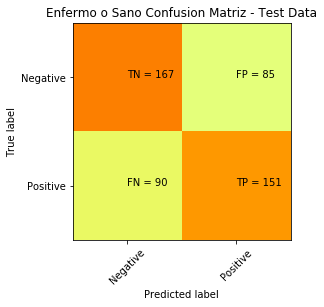


+ Classification Report
              precision    recall  f1-score   support

     enfermo       0.65      0.66      0.66       252
        sano       0.64      0.63      0.63       241

   micro avg       0.65      0.65      0.65       493
   macro avg       0.64      0.64      0.64       493
weighted avg       0.64      0.65      0.64       493



In [184]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Enfermo o Sano Confusion Matriz - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()
#TN = Verdadero Negativo(predijo - cuando era -)
#TP = Verdadero Positivo(predijo + cuando era +)
#FN = Falso Negativo(predijo - cuando era +)
#FP = Falso Positivo(predijo + cuando era -)

# Tambien podemos usar el reporte de clasificacion
print('\n+ Classification Report')
print(classification_report(Y_test, y_predicted))

In [135]:
#funcion predict_proba -> devuelve las probabilidades
model_predictions = model.predict_proba(X_test)
model_predictions.shape

(493, 2)


+ ROC


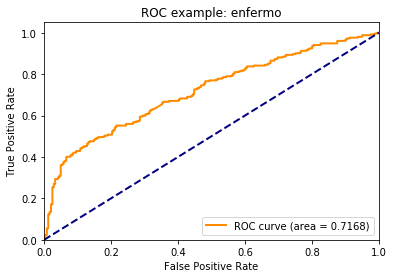

In [170]:
# Curva ROC ojo enfermo
print('\n+ ROC')
y_pred_scores = model_predictions[:, 0]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_scores, pos_label='enfermo') 
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC example: enfermo')
plt.legend(loc='lower right')
plt.show()


+ ROC


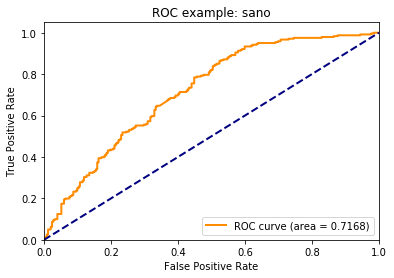

In [171]:
# Curva ROC ojo sano
print('\n+ ROC')
y_pred_scores = model_predictions[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_scores, pos_label='sano') 
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC example: sano')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Funcion para generar los features y labels -- nueva
def load2_images_from_folder(folder, label, model):
    features_labels = []

    for filename in tqdm(os.listdir(folder)):

        img_path = os.path.join(folder,filename)
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x)

        assert img is not None

        features_labels.append((feature,img_path))

    return features_labels

In [ ]:
nuevo = load2_images_from_folder("carpetadeprofe", "", mobile)

In [ ]:
x = []
for tupla in listas:
    x.append(tupla[0][0])

In [ ]:
# load the model from disk
loaded_model = joblib.load(filename)

In [ ]:
final = []
for new in nuevo:
    model_prediction = model.predict(new[0])
    final.append([new[1], model_prediction])

In [ ]:
#guardar en csv
with open('final.csv', 'wb') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['Nombre', 'Clase'])

In [ ]:
#guardar csv
data = {'nombre': ['Sigrid', 'Joe'],
        'clase': ['Mannock', 'Hinners']
       }

df = pd.DataFrame(data, columns = ['nombre', 'clase'])
df.to_csv('example.csv')